<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Simulation](05.00-Simulation.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Scheduling Multipurpose Batch Processes using State-Task Networks

The State-Task Network (STN) is an approach to modeling multipurpose batch process for the purpose of short term scheduling. It was first developed by Kondili, et al., in 1993, and subsequently developed and extended by others. 

### References

Floudas, C. A., & Lin, X. (2005). Mixed integer linear programming in process scheduling: Modeling, algorithms, and applications. Annals of Operations Research, 139(1), 131-162.

Harjunkoski, I., Maravelias, C. T., Bongers, P., Castro, P. M., Engell, S., Grossmann, I. E., ... & Wassick, J. (2014). Scope for industrial applications of production scheduling models and solution methods. Computers & Chemical Engineering, 62, 161-193.

Kondili, E., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—I. MILP formulation. Computers & Chemical Engineering, 17(2), 211-227.

Méndez, C. A., Cerdá, J., Grossmann, I. E., Harjunkoski, I., & Fahl, M. (2006). State-of-the-art review of optimization methods for short-term scheduling of batch processes. Computers & Chemical Engineering, 30(6), 913-946.

Shah, N., Pantelides, C. C., & Sargent, R. W. H. (1993). A general algorithm for short-term scheduling of batch operations—II. Computational issues. Computers & Chemical Engineering, 17(2), 229-244.

Wassick, J. M., & Ferrio, J. (2011). Extending the resource task network for industrial applications. Computers & chemical engineering, 35(10), 2124-2140.

## Example (Kondili, et al., 1993)

A state-task network is a graphical representation of the activities in a multiproduct batch process. The representation includes the minimum details needed for short term scheduling of batch operations.

A well-studied example due to Kondili (1993) is shown below. Other examples are available in the references cited above.

![](../../images/Kondili_1993.png)

Each circular node in the diagram designates material in a particular state.  The materials are generally held in suitable vessels with a known capacity. The relevant information for each state is the initial inventory, storage capacity, and the unit price of the material in each state. The price of materials in intermediate states may be assigned penalities in order to minimize the amount of work in progress.

The rectangular nodes denote process tasks. When scheduled for execution, each task is assigned an appropriate piece of equipment, and assigned a batch of material according to the incoming arcs. Each incoming arc begins at a state where the associated label indicates the mass fraction of the batch coming from that particular state. Outgoing arcs indicate the disposition of the batch to product states. The outgoing are labels indicate the fraction of the batch assigned to each product state, and the time necessary to produce that product. 

Not shown in the diagram is the process equipment used to execute the tasks. A separate list of process units is available, each characterized by a capacity and list of tasks which can be performed in that unit.

### Exercise

Read this reciped for Hollandaise Sauce: http://www.foodnetwork.com/recipes/tyler-florence/hollandaise-sauce-recipe-1910043. Assume the available equipment consists of one sauce pan and a double-boiler on a stove. Draw a state-task network outlining the basic steps in the recipe.

## Encoding the STN data

The basic data structure specifies the states, tasks, and units comprising a state-task network. The intention is for all relevant problem data to be contained in a single JSON-like structure.

In [1]:
H = 20

Kondili = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Feed_A'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Feed_B'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Feed_C'   : {'capacity': 500, 'initial': 500, 'price':  0},
        'Hot_A'    : {'capacity': 100, 'initial':   0, 'price': -1},
        'Int_AB'   : {'capacity': 200, 'initial':   0, 'price': -1},
        'Int_BC'   : {'capacity': 150, 'initial':   0, 'price': -1},
        'Impure_E' : {'capacity': 100, 'initial':   0, 'price': -1},
        'Product_1': {'capacity': 500, 'initial':   0, 'price': 10},
        'Product_2': {'capacity': 500, 'initial':   0, 'price': 10},
    },
    'ST_ARCS': {
        ('Feed_A',   'Heating')   : {'rho': 1.0},
        ('Feed_B',   'Reaction_1'): {'rho': 0.5},
        ('Feed_C',   'Reaction_1'): {'rho': 0.5},
        ('Feed_C',   'Reaction_3'): {'rho': 0.2},
        ('Hot_A',    'Reaction_2'): {'rho': 0.4},
        ('Int_AB',   'Reaction_3'): {'rho': 0.8},
        ('Int_BC',   'Reaction_2'): {'rho': 0.6},
        ('Impure_E', 'Separation'): {'rho': 1.0},
    },
    'TS_ARCS': {
        ('Heating',    'Hot_A')    : {'dur': 1, 'rho': 1.0},
        ('Reaction_2', 'Product_1'): {'dur': 1.5, 'rho': 0.4},
        ('Reaction_2', 'Int_AB')   : {'dur': 1.5, 'rho': 0.6},
        ('Reaction_1', 'Int_BC')   : {'dur': 2, 'rho': 1.0},
        ('Reaction_3', 'Impure_E') : {'dur': 1, 'rho': 1.0},
        ('Separation', 'Int_AB')   : {'dur': 2, 'rho': 0.1},
        ('Separation', 'Product_2'): {'dur': 1, 'rho': 0.9},
    },
    'UNIT_TASKS': {
        ('Heater',    'Heating')   : {'Bmin': 0, 'Bmax': 100, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_1'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_2'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_1', 'Reaction_3'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_1'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_2'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Reactor_2', 'Reaction_3'): {'Bmin': 0, 'Bmax':  80, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
        ('Still',     'Separation'): {'Bmin': 0, 'Bmax': 200, 'Cost': 1, 'vCost': 0, 'Tclean': 0},
    },
}

### Setting a Time Grid

The following computations can be done on any time grid, including real-valued time points. TIME is a list of time points commencing at 0.

## Creating a Pyomo Model

The following Pyomo model closely follows the development in Kondili, et al. (1993). In particular, the first step in the model is to process the STN data to create sets as given in Kondili.  

One important difference from Kondili is the adoption of a more natural time scale that starts at $t = 0$ and extends to $t = H$ (rather than from 1 to H+1).

A second difference is the introduction of an additional decision variable denoted by $Q_{j,t}$ indicating the amount of material in unit $j$ at time $t$. A material balance then reads

\begin{align*}
Q_{jt} & = Q_{j(t-1)} + \sum_{i\in I_j}B_{ijt} - \sum_{i\in I_j}\sum_{\substack{s \in \bar{S}_i\\s\ni t-P_{is} \geq 0}}\bar{\rho}_{is}B_{ij(t-P_{is})} \qquad \forall j,t
\end{align*}

Following Kondili's notation, $I_j$ is the set of tasks that can be performed in unit $j$, and $\bar{S}_i$ is the set of states fed by task $j$. We assume the units are empty at the beginning and end of production period, i.e.,

\begin{align*}
Q_{j(-1)} & = 0 \qquad \forall j \\
Q_{j,H} & = 0 \qquad \forall j
\end{align*}

The unit allocation constraints are written the full backward aggregation method described by Shah (1993).  The allocation constraint reads

\begin{align*}
\sum_{i \in I_j} \sum_{t'=t}^{t-p_i+1} W_{ijt'} & \leq 1 \qquad \forall j,t
\end{align*}

Each processing unit $j$ is tagged with a minimum and maximum capacity, $B_{ij}^{min}$ and $B_{ij}^{max}$, respectively, denoting the minimum and maximum batch sizes for each task $i$. A minimum capacity may be needed to cover heat exchange coils in a reactor or mixing blades in a blender, for example. The capacity may depend on the nature of the task being performed.  These constraints are written

\begin{align*}
B_{ij}^{min}W_{ijt} & \leq B_{ijt} \leq  B_{ij}^{max}W_{ijt} \qquad \forall j, \forall i\in I_j, \forall t
\end{align*}

### Characterization of Tasks

In [2]:
STN = Kondili

STATES = STN['STATES']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
TIME = STN['TIME']
H = max(TIME)

In [3]:
TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j) 

### Characterization of States

In [4]:
T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s

### Characterization of Units

In [5]:
UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i

### Pyomo Model

In [6]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])) 

# unit constraints
for j in UNITS:
    rhs = 0
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Konkili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        model.cons.add(model.Q[j,t] == rhs)
        rhs = model.Q[j,t]
        
    # terminal condition  
    model.cons.add(model.Q[j,H] == 0)

# state constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        
        # state mass balanace
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]             
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
        model.cons.add(model.S[s,t] == rhs)
        rhs = model.S[s,t] 
        
# additional production constraints      
model.cons.add(model.S['Product_2',H] >= 250)

SolverFactory('glpk').solve(model).write()

  Signal handler called from  /Users/jeff/anaconda3/lib/python3.6/subprocess.py _try_wait 1404
  Waiting...
  Signaled process 30126 with signal 2
ERROR: Solver (glpk) returned non-zero return code (-1)
ERROR: Solver log: GLPSOL: GLPK LP/MIP Solver, v4.65 Parameter(s) specified in
    the command line:
     --write /Users/jeff/Dropbox/Git/ND-Pyomo-
         Cookbook/notebooks/scheduling/tmp0uvmbh6h.glpk.raw --wglp
         /Users/jeff/Dropbox/Git/ND-Pyomo-
         Cookbook/notebooks/scheduling/tmpr8n6to0a.glpk.glp --cpxlp
         /Users/jeff/Dropbox/Git/ND-Pyomo-
         Cookbook/notebooks/scheduling/tmpjuds8idv.pyomo.lp
    Reading problem data from '/Users/jeff/Dropbox/Git/ND-Pyomo-
    Cookbook/notebooks/scheduling/tmpjuds8idv.pyomo.lp'...
    /Users/jeff/Dropbox/Git/ND-Pyomo-
    Cookbook/notebooks/scheduling/tmpjuds8idv.pyomo.lp:5778: warning: lower
    bound of variable 'x1' redefined /Users/jeff/Dropbox/Git/ND-Pyomo-
    Cookbook/notebooks/scheduling/tmpjuds8idv.pyomo.lp:5778

ApplicationError: Solver (glpk) did not exit normally

## Analysis

### Profitability



In [ ]:
print("Value of State Inventories = {0:12.2f}".format(model.Value()))
print("  Cost of Unit Assignments = {0:12.2f}".format(model.Cost()))
print("             Net Objective = {0:12.2f}".format(model.Value() - model.Cost()))

### State Inventories

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

pd.DataFrame([[model.S[s,t]() for s in STATES.keys()] for t in TIME], columns = STATES.keys(), index = TIME)

,Feed_A,Feed_B,Feed_C,Hot_A,Int_AB,Int_BC,Impure_E,Product_1,Product_2
0,500.0,420.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0
1,440.0,420.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0
2,340.0,380.0,380.0,28.0,0.0,112.0,0.0,0.0,0.0
3,340.0,380.0,380.0,96.0,0.0,64.0,0.0,0.0,0.0
4,340.0,380.0,380.0,32.0,48.0,48.0,0.0,32.0,0.0
5,340.0,380.0,364.0,0.0,32.0,0.0,0.0,64.0,0.0
6,340.0,380.0,348.0,0.0,64.0,0.0,0.0,128.0,0.0
7,340.0,380.0,324.0,0.0,16.0,0.0,80.0,160.0,72.0
8,340.0,380.0,324.0,0.0,24.0,0.0,0.0,160.0,72.0
9,340.0,380.0,324.0,0.0,24.0,0.0,0.0,160.0,252.0


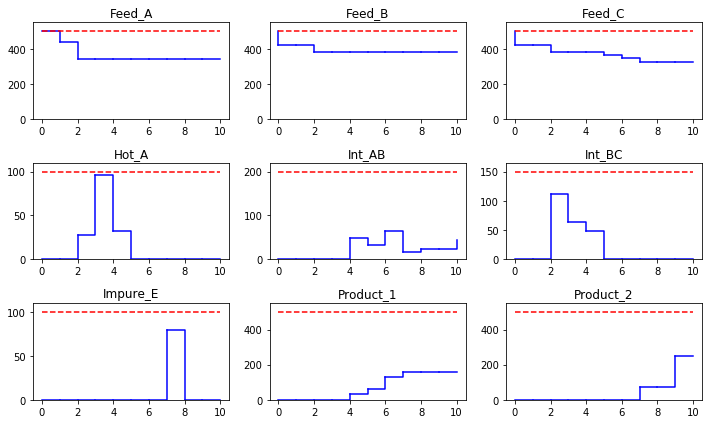

In [9]:
plt.figure(figsize=(10,6))
for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
    plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
    tlast,ylast = 0,STATES[s]['initial']
    for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
        plt.plot([tlast,t,t],[ylast,ylast,y],'b')
        #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
        tlast,ylast = t,y
    plt.ylim(0,1.1*C[s])
    plt.plot([0,H],[C[s],C[s]],'r--')
    plt.title(s)
plt.tight_layout()

### Unit Assignment

In [10]:
UnitAssignment = pd.DataFrame({j:[None for t in TIME] for j in UNITS},index=TIME)

for t in TIME:
    for j in UNITS:
        for i in I[j]:
            for s in S_[i]:
                if t-p[i] >= 0:
                    if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                        UnitAssignment.loc[t,j] = None               
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                UnitAssignment.loc[t,j] = (i,model.B[i,j,t]())

UnitAssignment

,Heater,Reactor_1,Reactor_2,Still
0,None,"(Reaction_1, 80.0)","(Reaction_1, 80.0)",None
1,"(Heating, 60.0)",None,None,None
2,"(Heating, 100.0)","(Reaction_1, 80.0)","(Reaction_2, 80.0)",None
3,None,None,"(Reaction_2, 80.0)",None
4,None,"(Reaction_2, 80.0)","(Reaction_2, 80.0)",None
5,None,"(Reaction_3, 80.0)","(Reaction_2, 80.0)",None
6,None,None,"(Reaction_3, 80.0)","(Separation, 80.0)"
7,None,"(Reaction_3, 40.0)","(Reaction_3, 80.0)",None
8,None,None,None,"(Separation, 200.0)"
9,None,None,None,None


### Unit Batch Inventories

In [11]:
pd.DataFrame([[model.Q[j,t]() for j in UNITS] for t in TIME], columns = UNITS, index = TIME)

,Still,Reactor_1,Reactor_2,Heater
0,0.0,80.0,80.0,0.0
1,0.0,80.0,80.0,60.0
2,0.0,80.0,80.0,100.0
3,0.0,80.0,160.0,0.0
4,0.0,80.0,160.0,0.0
5,0.0,160.0,160.0,0.0
6,80.0,0.0,160.0,0.0
7,8.0,40.0,80.0,0.0
8,200.0,0.0,0.0,0.0
9,20.0,0.0,0.0,0.0


### Gannt Chart

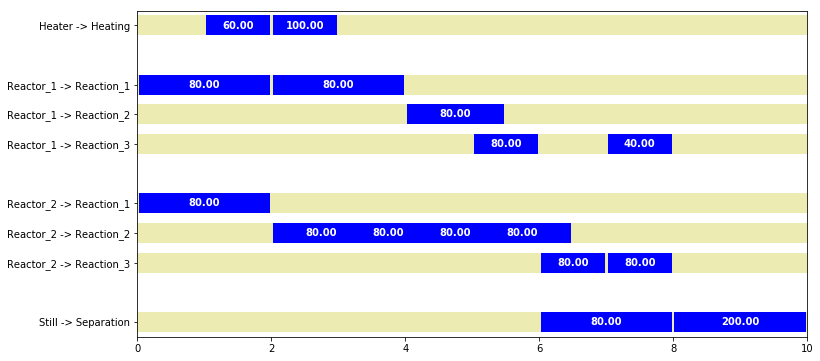

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.2f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

## Trace of Events and States

In [13]:
sep = '\n--------------------------------------------------------------------------------------------\n'
print(sep)
print("Starting Conditions")
print("    Initial Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,STATES[s]['initial']))
        
units = {j:{'assignment':'None', 't':0} for j in UNITS}

for t in TIME:
    print(sep)
    print("Time =",t,"hr")
    print("    Instructions:")
    for j in UNITS:
        units[j]['t'] += 1
        # transfer from unit to states
        for i in I[j]:  
            for s in S_[i]:
                if t-P[(i,s)] >= 0:
                    amt = rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t - P[(i,s)]])]()
                    if amt > 0:
                        print("        Transfer", amt, "kg from", j, "to", s)
    for j in UNITS:
        # release units from tasks
        for i in I[j]:
            if t-p[i] >= 0:
                if model.W[i,j,max(TIME[TIME <= t-p[i]])]() > 0:
                    print("        Release", j, "from", i)
                    units[j]['assignment'] = 'None'
                    units[j]['t'] = 0
        # assign units to tasks             
        for i in I[j]:
            if model.W[i,j,t]() > 0:
                print("        Assign", j, "with capacity", Bmax[(i,j)], "kg to task",i,"for",p[i],"hours")
                units[j]['assignment'] = i
                units[j]['t'] = 1
        # transfer from states to starting tasks
        for i in I[j]:
            for s in S[i]:
                amt = rho[(i,s)]*model.B[i,j,t]()
                if amt > 0:
                    print("        Transfer", amt,"kg from", s, "to", j)
    print("\n    Inventories are now:")            
    for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,t]()))
    print("\n    Unit Assignments are now:")
    for j in UNITS:
        if units[j]['assignment'] != 'None':
            fmt = "        {0:s} performs the {1:s} task with a {2:.2f} kg batch for hour {3:f} of {4:f}"
            i = units[j]['assignment']
            print(fmt.format(j,i,model.Q[j,t](),units[j]['t'],p[i]))
            
print(sep)
print('Final Conditions')
print("    Final Inventories:")            
for s in STATES.keys():
        print("        {0:10s}  {1:6.1f} kg".format(s,model.S[s,H]()))



--------------------------------------------------------------------------------------------

Starting Conditions
    Initial Inventories:
        Feed_A       500.0 kg
        Feed_B       500.0 kg
        Feed_C       500.0 kg
        Hot_A          0.0 kg
        Int_AB         0.0 kg
        Int_BC         0.0 kg
        Impure_E       0.0 kg
        Product_1      0.0 kg
        Product_2      0.0 kg

--------------------------------------------------------------------------------------------

Time = 0 hr
    Instructions:
        Assign Reactor_1 with capacity 80 kg to task Reaction_1 for 2 hours
        Transfer 40.0 kg from Feed_C to Reactor_1
        Transfer 40.0 kg from Feed_B to Reactor_1
        Assign Reactor_2 with capacity 80 kg to task Reaction_1 for 2 hours
        Transfer 40.0 kg from Feed_C to Reactor_2
        Transfer 40.0 kg from Feed_B to Reactor_2

    Inventories are now:
        Feed_A       500.0 kg
        Feed_B       420.0 kg
        Feed_C       420.0 

<!--NAVIGATION-->
< [Job Shop Scheduling](04.02-Job-Shop-Scheduling.ipynb) | [Contents](index.ipynb) | [Simulation](05.00-Simulation.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Scheduling-Multipurpose-Batch-Processes-using-State-Task_Networks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
